This notebook analyzes the distribution of the number of edges and hyperedges in each time interval.

In [12]:
using GrootSim

using CSV
using DataFrames
using Dates
using DotEnv
DotEnv.load!()
using PyPlot
using Serialization
using SimpleHypergraphs
using Statistics

using PyCall
pickle = pyimport("pickle");

## Loading the data

In [ ]:
basepath = ENV["BASEPATH"]
datapath = ENV["DATA_PATH"]
data_to_include_path = ENV["DATA_TO_INCLUDE_PATH"];
precomputed_params_path = ENV["PRECOMPUTED_PARAMS_PATH"];

In [8]:
day_params_path = joinpath(precomputed_params_path, "day");

In [9]:
reddittors_to_include = Set(pickle.load(open(joinpath(data_to_include_path, "final_users_to_include.pkl"))))
subs_to_include = (pickle.load(open(joinpath(data_to_include_path, "final_subs_to_include.pkl"))))
subs_to_include = Set([sub_id[4:end] for sub_id in subs_to_include]);

## Compute hyperedge size 
In other words, we count the number of users contributing to each subthread in a submission during each time interval

In [ ]:
subreddits_to_eval = [
    "AskReddit",
    "bayarea",
    "California",
    "collapse",
    "news",
    "politics",
]

In [ ]:
for subreddit in subreddits_to_eval
    he_sizes = Array{Array{Int, 1}, 1}()
    snap_he_sizes = Array{Array{Int, 1}, 1}()

    subreddits_to_include = Set{String}()
    push!(subreddits_to_include, split(subreddit, "_")...)
    println("Evaluating: ", subreddits_to_include)

    # data
    sim_intervals = deserialize(open(joinpath(day_params_path, subreddit, "sim_intervals.ser"), "r"))
    intervals = deserialize(open(joinpath(day_params_path, subreddit, "intervals.ser"), "r"))
    println(length(intervals), " ", length(sim_intervals))

    # get hyperedge size based on sliding window
    for (i, period) in enumerate(sim_intervals)
        (i%50 == 0) && println("evaluating period $i/$(length(sim_intervals))")
        s_date = period.first
        obs_date = period.second

        hg, v_to_id, he_to_id = create_subreddits_hg(
            datapath,
            subs_to_include,
            reddittors_to_include;
            mindate=s_date,
            maxdate=obs_date,
            subreddits_to_include=subreddits_to_include,
            ignore_NI=true,
            verbose=false
        )

        _he_sizes = [length(getvertices(hg, he)) for he in 1:nhe(hg)]
        push!(he_sizes, _he_sizes)
    end 

    # hyperedge size based on temporal snapshots
    left = Dates.DateTime(2020, 07, 1, 0, 0, 0)

    for (i, right) in enumerate(intervals)
        (i%50 == 0) && println("evaluating period $i/$(length(intervals)): $left - $right")
        s_date = left
        obs_date = right
    
        hg, v_to_id, he_to_id = create_subreddits_hg(
            datapath,
            subs_to_include,
            reddittors_to_include;
            mindate=s_date,
            maxdate=right,
            subreddits_to_include=subreddits_to_include,
            ignore_NI=true,
            verbose=false
        )
    
        left = right
    
        _he_sizes = [length(getvertices(hg, he)) for he in 1:nhe(hg)]
        push!(snap_he_sizes, _he_sizes)
    end 

    # serialize(joinpath(outpath, "$(subreddit)_he_sizes.ser"), he_sizes)
    # serialize(joinpath(outpath, "snap_$(subreddit)_he_sizes.ser"), snap_he_sizes)
end

Evaluating: Set(["AskReddit"])
913 867
evaluating period 10/867
evaluating period 20/867
evaluating period 30/867
evaluating period 40/867
evaluating period 50/867
evaluating period 60/867
evaluating period 70/867
evaluating period 80/867
evaluating period 90/867
evaluating period 100/867
evaluating period 110/867
evaluating period 120/867
evaluating period 130/867
evaluating period 140/867
evaluating period 150/867
evaluating period 160/867
evaluating period 170/867
evaluating period 180/867
evaluating period 190/867
evaluating period 200/867
evaluating period 210/867
evaluating period 220/867
evaluating period 230/867
evaluating period 240/867
evaluating period 250/867
evaluating period 260/867
evaluating period 270/867
evaluating period 280/867
evaluating period 290/867
evaluating period 300/867
evaluating period 310/867
evaluating period 320/867
evaluating period 330/867
evaluating period 340/867
evaluating period 350/867
evaluating period 360/867
evaluating period 370/867
evaluati

## Loading hyperedge size data

In [15]:
he_sizes_path = ENV["HE_SIZES_PATH"]
he_sizes_path = joinpath(he_sizes_path, "across_nets");

In [16]:
# # he sizes 
askreddit_he_sizes = deserialize(open(joinpath(he_sizes_path, "AskReddit_he_sizes.ser"), "r"))
bayarea_he_sizes = deserialize(open(joinpath(he_sizes_path, "bayarea_he_sizes.ser"), "r"))
california_he_sizes = deserialize(open(joinpath(he_sizes_path, "California_he_sizes.ser"), "r"))
collapse_he_sizes = deserialize(open(joinpath(he_sizes_path, "collapse_he_sizes.ser"), "r"))
news_he_sizes = deserialize(open(joinpath(he_sizes_path, "news_he_sizes.ser"), "r"))
politics_he_sizes = deserialize(open(joinpath(he_sizes_path, "politics_he_sizes.ser"), "r"))
;

# he sizes 
snap_askreddit_he_sizes = deserialize(open(joinpath(he_sizes_path, "snap_AskReddit_he_sizes.ser"), "r"))
snap_bayarea_he_sizes = deserialize(open(joinpath(he_sizes_path, "snap_bayarea_he_sizes.ser"), "r"))
snap_california_he_sizes = deserialize(open(joinpath(he_sizes_path, "snap_California_he_sizes.ser"), "r"))
snap_collapse_he_sizes = deserialize(open(joinpath(he_sizes_path, "snap_collapse_he_sizes.ser"), "r"))
snap_news_he_sizes = deserialize(open(joinpath(he_sizes_path, "snap_news_he_sizes.ser"), "r"))
snap_politics_he_sizes = deserialize(open(joinpath(he_sizes_path, "snap_politics_he_sizes.ser"), "r"))
;

## Prepare the data to plot

In [10]:
function prepare_data(he_sizes::Array{Array{Int, 1}, 1})
    to_return = Array{Array{Float64, 1}, 1}()
    
    for (idx, _he_sizes) in enumerate(he_sizes)
        n_he = length(_he_sizes)

        singletons = length([he for he in _he_sizes if he == 1])/n_he
        edge = length([he for he in _he_sizes if he == 2])/n_he
        he = length([he for he in _he_sizes if he > 2])/n_he

        push!(to_return, [singletons, edge, he])
    end

    to_return
end

prepare_data (generic function with 1 method)

In [17]:
# singletons, edges, hyperedges
askreddit_data = prepare_data(askreddit_he_sizes)
bayarea_data = prepare_data(bayarea_he_sizes)
california_data = prepare_data(california_he_sizes)
collapse_data = prepare_data(collapse_he_sizes)
news_data = prepare_data(news_he_sizes)
politics_data = prepare_data(politics_he_sizes)
;

In [18]:
# singletons, edges, hyperedges
snap_askreddit_data = prepare_data(snap_askreddit_he_sizes)
snap_bayarea_data = prepare_data(snap_bayarea_he_sizes)
snap_california_data = prepare_data(snap_california_he_sizes)
snap_collapse_data = prepare_data(snap_collapse_he_sizes)
snap_news_data = prepare_data(snap_news_he_sizes)
snap_politics_data = prepare_data(snap_politics_he_sizes)
;

## Plot the results

### Bar chart

In [19]:
function generate_bar_plot(ax, data)

    bottom = zeros(length(data))

    for (sim_interval, interval_data) in enumerate(data)
        for (idx, d) in enumerate(interval_data)
            ax.bar(
                sim_interval,
                d,
                width,
                label=labels[idx],
                color=colors[idx],
                bottom=bottom[sim_interval]
            )
            bottom[sim_interval] += d
        end
    end
end

generate_bar_plot (generic function with 1 method)

#### Sliding-window

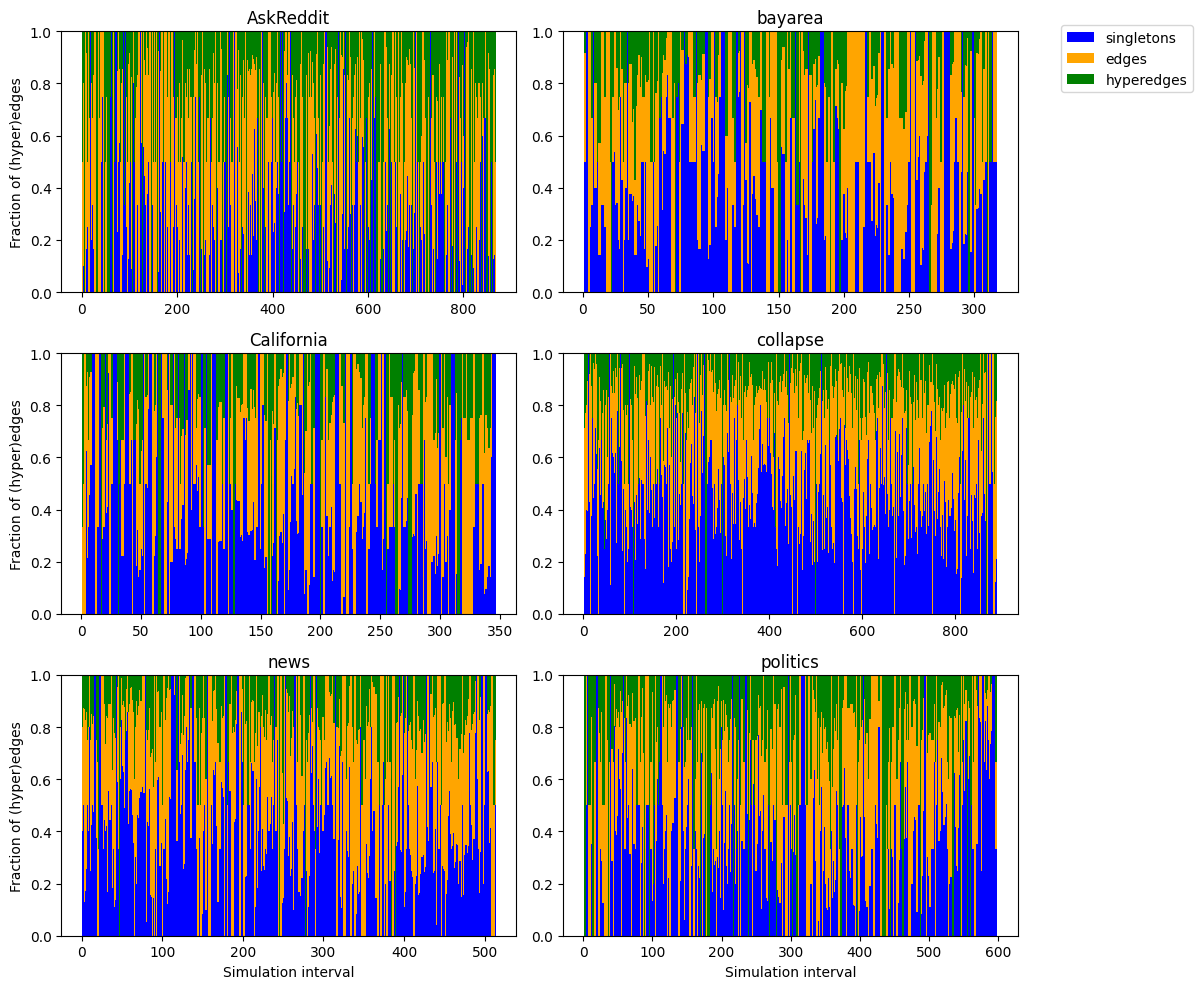

In [25]:
clf()

fig, ax = plt.subplots(3, 2, figsize=(12, 10))

labels = ["singletons", "edges", "hyperedges"]
colors = ["blue", "orange", "green"]
width = 1

generate_bar_plot(ax[1, 1], askreddit_data)
generate_bar_plot(ax[1, 2], bayarea_data)
generate_bar_plot(ax[2, 1], california_data)
generate_bar_plot(ax[2, 2], collapse_data)
generate_bar_plot(ax[3, 1], news_data)
generate_bar_plot(ax[3, 2], politics_data)

# x infos
# set x axis labels
ax[3,1].set_xlabel("Simulation interval")
ax[3,2].set_xlabel("Simulation interval")

# set y axis labels
ax[1,1].set_ylabel("Fraction of (hyper)edges")
ax[2,1].set_ylabel("Fraction of (hyper)edges")
ax[3,1].set_ylabel("Fraction of (hyper)edges")

# set titles
ax[1,1].set_title("AskReddit")
ax[1,2].set_title("bayarea")
ax[2,1].set_title("California")
ax[2,2].set_title("collapse")
ax[3,1].set_title("news")
ax[3,2].set_title("politics")

ax[1,2].legend(labels, loc="upper right", bbox_to_anchor=(1.4, 1.05))

plt.tight_layout()
gcf()
# savefig(joinpath(he_sizes_path, "plots", "hyperedges_distribution_sim_intervals.png"))

#### Snapshots

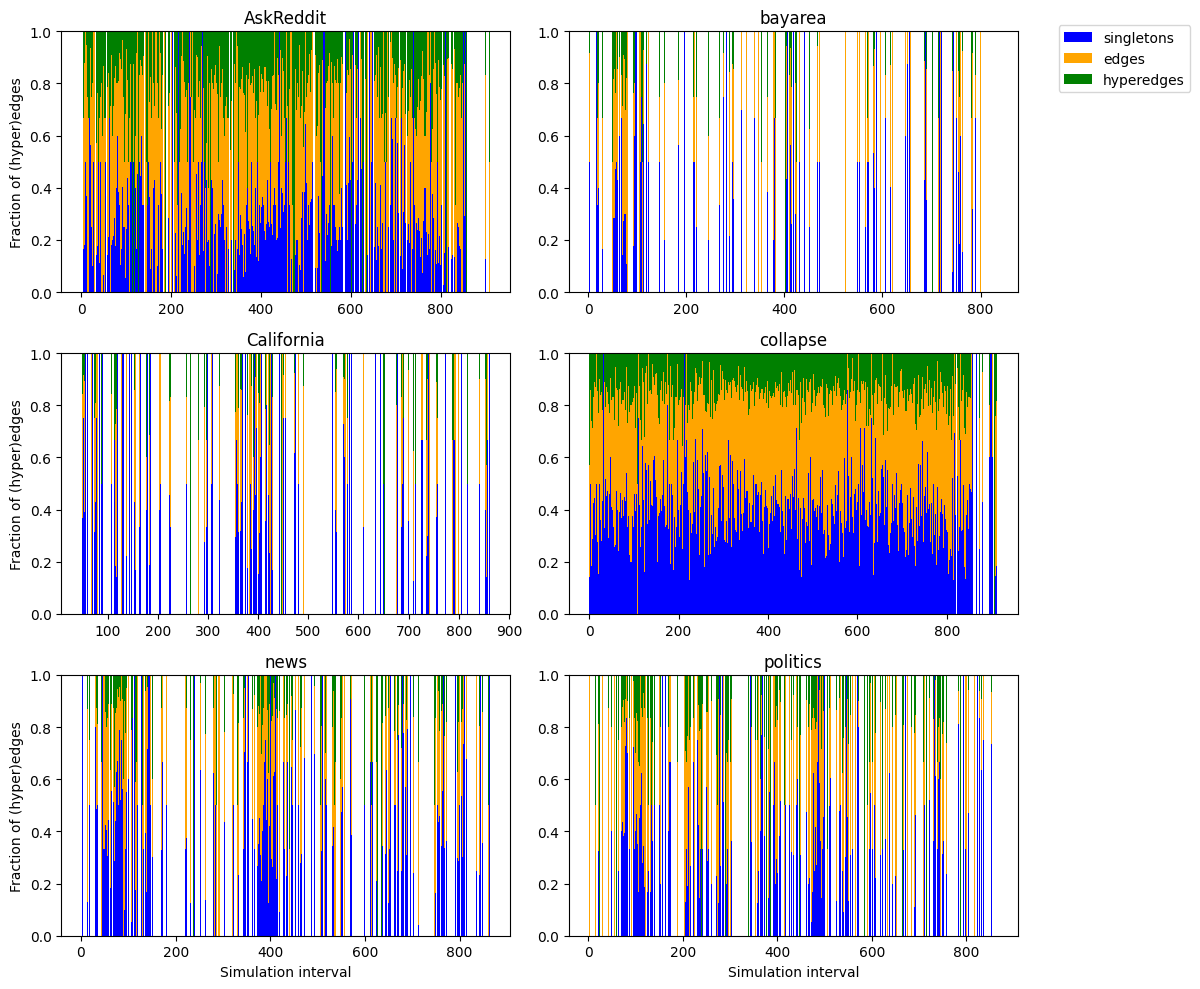

In [26]:
clf()

fig, ax = plt.subplots(3, 2, figsize=(12, 10))

labels = ["singletons", "edges", "hyperedges"]
colors = ["blue", "orange", "green"]
width = 1

generate_bar_plot(ax[1, 1], snap_askreddit_data)
generate_bar_plot(ax[1, 2], snap_bayarea_data)
generate_bar_plot(ax[2, 1], snap_california_data)
generate_bar_plot(ax[2, 2], snap_collapse_data)
generate_bar_plot(ax[3, 1], snap_news_data)
generate_bar_plot(ax[3, 2], snap_politics_data)

# x infos
# set x axis labels
ax[3,1].set_xlabel("Simulation interval")
ax[3,2].set_xlabel("Simulation interval")

# set y axis labels
ax[1,1].set_ylabel("Fraction of (hyper)edges")
ax[2,1].set_ylabel("Fraction of (hyper)edges")
ax[3,1].set_ylabel("Fraction of (hyper)edges")

# set titles
ax[1,1].set_title("AskReddit")
ax[1,2].set_title("bayarea")
ax[2,1].set_title("California")
ax[2,2].set_title("collapse")
ax[3,1].set_title("news")
ax[3,2].set_title("politics")

ax[1,2].legend(labels, loc="upper right", bbox_to_anchor=(1.4, 1.05))

plt.tight_layout()
gcf()
# savefig(joinpath(outpath, "plots", "hyperedges_distribution_snapshots.png"))

### Boxplot

In [27]:
# singletons, edges, hyperedges
function get_boxplot_data(data)

    singletons = [d[1] for d in data if !isnan(d[1])]
    edges = [d[2] for d in data if !isnan(d[2])]
    hyperedges = [d[3] for d in data if !isnan(d[3])]

    singletons, edges, hyperedges
end

get_boxplot_data (generic function with 1 method)

In [28]:
function set_box_color(bp, color)
    plt.setp(bp["boxes"], color=color)
    plt.setp(bp["whiskers"], color=color)
    plt.setp(bp["caps"], color=color)
    plt.setp(bp["medians"], color=color)
end

set_box_color (generic function with 1 method)

#### Sliding window

In [29]:
singletons = Array{Array{Float64, 1}, 1}()
edges = Array{Array{Float64, 1}, 1}()
hes = Array{Array{Float64, 1}, 1}()

s, e, h = get_boxplot_data(askreddit_data)
push!(singletons, s)
push!(edges, e)
push!(hes, h)
;

s, e, h = get_boxplot_data(bayarea_data)
push!(singletons, s)
push!(edges, e)
push!(hes, h)
;

s, e, h = get_boxplot_data(california_data)
push!(singletons, s)
push!(edges, e)
push!(hes, h)
;

s, e, h = get_boxplot_data(collapse_data)
push!(singletons, s)
push!(edges, e)
push!(hes, h)
;

s, e, h = get_boxplot_data(news_data)
push!(singletons, s)
push!(edges, e)
push!(hes, h)
;

s, e, h = get_boxplot_data(politics_data)
push!(singletons, s)
push!(edges, e)
push!(hes, h)
;

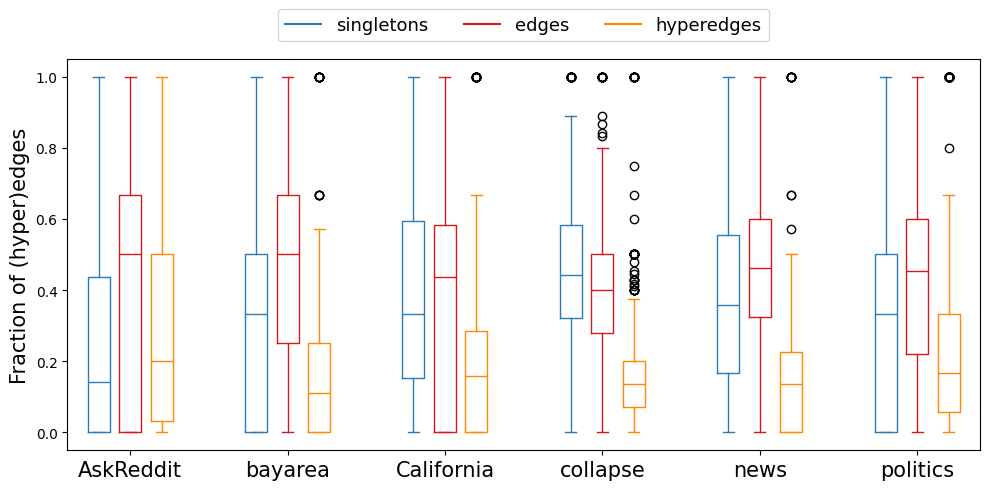

In [31]:
clf()

fig, ax = plt.subplots(1, figsize=(10, 5))

labels = ["singletons", "edges", "hyperedges"]
xtickslabels = ["AskReddit", "bayarea", "California", "collapse", "news", "politics"]
colorz=["#2C7BB6", "#D7191C", "#FF8900", "#33CC33", "#cc0099", "#4d4dff", "#008080", "#2C7BB6"]

c = 1
val = -0.7
width = 0.35
mol = 2.5

b = plt.boxplot(singletons, positions=range(1, length(singletons))*mol.+val, widths=width)
set_box_color(b, colorz[c])
plt.plot([], c=colorz[c], label=labels[c])
c += 1

val+=0.5
b = plt.boxplot(edges, positions=range(1, length(edges))*mol.+val, widths=width)
set_box_color(b, colorz[c])
plt.plot([], c=colorz[c], label=labels[c])
c += 1

val+=0.5
b = plt.boxplot(hes, positions=range(1, length(hes))*mol.+val, widths=width)
set_box_color(b, colorz[c])
plt.plot([], c=colorz[c], label=labels[c])

plt.xticks(range(2.3, (length(singletons))*2.5, step=2.5), xtickslabels, fontsize="15", rotation=0)

plt.ylabel("Fraction of (hyper)edges", fontsize="15")

plt.legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.15), fontsize="13")

# plt.title("Incremental window")

plt.tight_layout()
gcf()
# savefig(joinpath(outpath, "plots", "hyperedges_distribution_boxplot.png"))

#### Snapshots

In [32]:
singletons = Array{Array{Float64, 1}, 1}()
edges = Array{Array{Float64, 1}, 1}()
hes = Array{Array{Float64, 1}, 1}()

s, e, h = get_boxplot_data(snap_askreddit_data)
push!(singletons, s)
push!(edges, e)
push!(hes, h)
;

s, e, h = get_boxplot_data(snap_bayarea_data)
push!(singletons, s)
push!(edges, e)
push!(hes, h)
;

s, e, h = get_boxplot_data(snap_california_data)
push!(singletons, s)
push!(edges, e)
push!(hes, h)
;

s, e, h = get_boxplot_data(snap_collapse_data)
push!(singletons, s)
push!(edges, e)
push!(hes, h)
;

s, e, h = get_boxplot_data(snap_news_data)
push!(singletons, s)
push!(edges, e)
push!(hes, h)
;

s, e, h = get_boxplot_data(snap_politics_data)
push!(singletons, s)
push!(edges, e)
push!(hes, h)
;

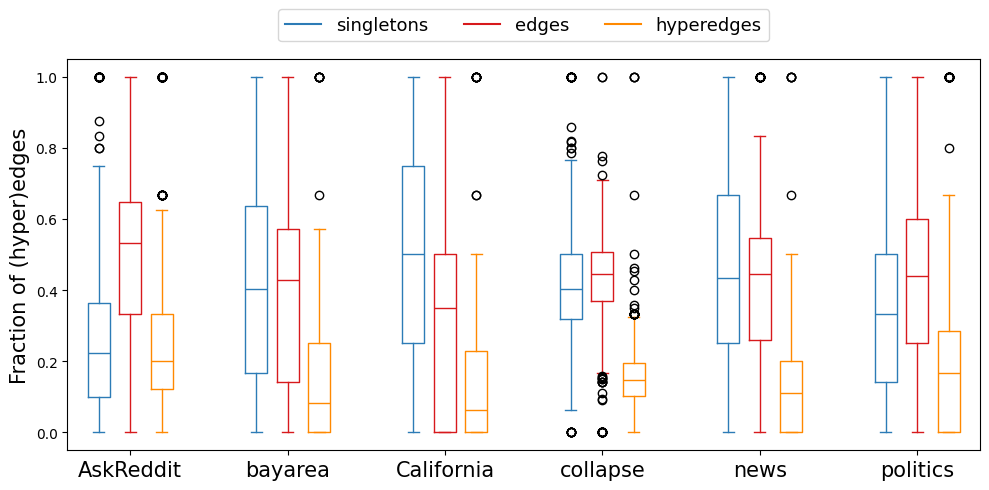

In [33]:
clf()

fig, ax = plt.subplots(1, figsize=(10, 5))

labels = ["singletons", "edges", "hyperedges"]
xtickslabels = ["AskReddit", "bayarea", "California", "collapse", "news", "politics"]
colorz=["#2C7BB6", "#D7191C", "#FF8900", "#33CC33", "#cc0099", "#4d4dff", "#008080", "#2C7BB6"]

c = 1
val = -0.7
width = 0.35
mol = 2.5

b = plt.boxplot(singletons, positions=range(1, length(singletons))*mol.+val, widths=width)
set_box_color(b, colorz[c])
plt.plot([], c=colorz[c], label=labels[c])
c += 1

val+=0.5
b = plt.boxplot(edges, positions=range(1, length(edges))*mol.+val, widths=width)
set_box_color(b, colorz[c])
plt.plot([], c=colorz[c], label=labels[c])
c += 1

val+=0.5
b = plt.boxplot(hes, positions=range(1, length(hes))*mol.+val, widths=width)
set_box_color(b, colorz[c])
plt.plot([], c=colorz[c], label=labels[c])

plt.xticks(range(2.3, (length(singletons))*2.5, step=2.5), xtickslabels, fontsize="15", rotation=0)

plt.ylabel("Fraction of (hyper)edges", fontsize="15")

plt.legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.15), fontsize="13")

# plt.title("Incremental window")

plt.tight_layout()
gcf()
# savefig(joinpath(outpath, "plots", "hyperedges_distribution_snapshots_boxplot.png"))